In [3]:
!pip install geopandas
!pip install bertopic
!pip install sentence-transformers
!pip install nltk spacy
!python -m spacy download en_core_web_sm
!pip install matplotlib_venn

INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
  Using cached thinc-8.3.1.tar.gz (193 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [37 lines of output]
      Ignoring numpy: markers 'python_version >= "3.9"' don't match your environment
        Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached murmurhash-1.0.10-cp38-cp38-win_amd64.whl.metadata (2.0 kB)
        Using cached cymem-2.0.8-cp38-cp38-win_amd64.whl.metadata (8.6 kB)
        Using cached preshed-3.0.9-cp38-cp38-win_amd64.whl.metadata (2.2 kB)
        Using cached blis-1.0.1.tar.gz (3.6 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'error'
        error: subprocess-exited-with-error
      
        × pip subprocess to install build dependencies did not run successfully.
        │ exit code: 1
        ╰─> [7 lines of output]
              Using cac

# Initial analysis

In [5]:
# Modules to import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import seaborn as sns

### Data preprocessing

### Original data

In [ ]:
# Execute dataCleaning.py
# This script create dictionaries of freebase_id, convert date to datetime object, transform our columns

#%run src/scripts/dataCleaning.py

Movies successfully loaded
Characters successfully loaded
Clusters successfully loaded
Summaries successfully loaded
Dates successfully converted
Build of countries dictionnary...
Build of languages dictionnary...
Build of genres dictionnary...
Build of actors dictionnary...
Build of character dictionnary...
Build of movies dictionnary...
Dictionnaries successfully saved
Saved movies_cleaned to data/cleanData/movies_cleaned.csv
Saved characters_cleaned to data/cleanData/characters_cleaned.csv
Saved character_clusters_cleaned to data/cleanData/character_clusters_cleaned.csv
Saved summaries_cleaned to data/cleanData/summaries_cleaned.csv
Datasets successfully saved
Data cleaning successfully done


Load the data

In [5]:
# Import dataloader function
path = 'src/data'
sys.path.append(path)
from dataLoader import loadDataframe

In [6]:
# Load data
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)
df_characters = loadDataframe('characters', path_to_directory)
df_clusters = loadDataframe('clusters', path_to_directory)
df_summaries = loadDataframe('summaries', path_to_directory)

Data statistics overview

In [7]:
print(df_movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                81741 non-null  int64         
 1   freebase_id            81741 non-null  object        
 2   original_title         81741 non-null  object        
 3   release_date           74839 non-null  datetime64[ns]
 4   revenue                8401 non-null   float64       
 5   runtime                61291 non-null  float64       
 6   languages              81741 non-null  object        
 7   countries              81741 non-null  object        
 8   genres                 81741 non-null  object        
 9   countries_freebase_id  81741 non-null  object        
 10  languages_freebase_id  81741 non-null  object        
 11  genres_freebase_id     81741 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory

In [8]:
df_movies.describe()

,wiki_id,release_date,revenue,runtime
count,8.174100e+04,74839,8.401000e+03,6.129100e+04
mean,1.740784e+07,1977-10-12 15:39:00.849022592,4.799363e+07,1.118192e+02
min,3.300000e+02,1888-01-01 00:00:00,1.000000e+04,0.000000e+00
25%,7.323695e+06,1956-01-01 00:00:00,2.083193e+06,8.100000e+01
50%,1.777899e+07,1985-05-20 00:00:00,1.063969e+07,9.300000e+01
75%,2.715573e+07,2004-01-01 00:00:00,4.071696e+07,1.060000e+02
max,3.750192e+07,2016-06-08 00:00:00,2.782275e+09,1.079281e+06
std,1.098791e+07,NaN,1.121753e+08,4.360070e+03


In [9]:
# Non null values proportion
df_movies.isnull().mean()

wiki_id                  0.000000
freebase_id              0.000000
original_title           0.000000
release_date             0.084437
revenue                  0.897224
runtime                  0.250180
languages                0.000000
countries                0.000000
genres                   0.000000
countries_freebase_id    0.000000
languages_freebase_id    0.000000
genres_freebase_id       0.000000
dtype: float64

The features that we are interested in are the following:
- 'release_date' : more than 80% of the movies have a release date
- 'genre' : 100% of the movies have a genre
- 'countries' : 100% of the movies have a country
- 'languages' : 100% of the movies have a language

So we have a large amount of non null values that we can use to make our analysis. 

In [10]:
from matplotlib_venn import venn2

def intersectionWikiId(df1, df2, name1, name2, id_column='id'):
    # Ids extraction from each DataFrame
    ids1 = set(df1[id_column].unique())
    ids2 = set(df2[id_column].unique())
    
    # Compute intersection and differences
    intersection = ids1 & ids2
    only_df1 = ids1 - ids2
    only_df2 = ids2 - ids1
    
    # Count elements
    count_intersection = len(intersection)
    count_only_df1 = len(only_df1)
    count_only_df2 = len(only_df2)
    total = count_intersection + count_only_df1 + count_only_df2

    # Venn diagram
    venn = venn2(subsets=(1, 1, 1), set_labels=(name1, name2))
    
    # Add counts
    venn.get_label_by_id('10').set_text(f'{count_only_df1}')
    venn.get_label_by_id('01').set_text(f'{count_only_df2}')
    venn.get_label_by_id('11').set_text(f'{count_intersection}')
    
    plt.title("Intersection between " + name1 + " and " + name2)
    plt.show()

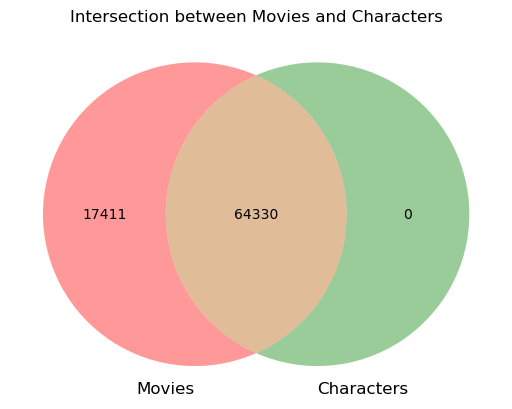

In [11]:
intersectionWikiId(df_movies, df_characters, 'Movies', 'Characters', id_column='wiki_id')

### Additional data

In [2]:
#Execute additionaldataCleaning.py
#This script create dictionaries of freebase_id, convert date to datetime object, transform our columns TO CHANGE

%run src/scripts/additionaldataCleaning.py

Additional Movies successfully loaded
Monthly inflation data successfully loaded
Budget successfully converted
Filtered additional movie data successfully created
Inflation data successfully processed
Saved Kaggle_US_CPI_monthly_cleaned to data/cleanData/Kaggle_US_CPI_monthly_cleaned.csv
Saved monthly inflation data to Kaggle_US_CPI_monthly_cleaned.csv
Saved Kaggle_US_CPI_annual_cleaned to data/cleanData/Kaggle_US_CPI_annual_cleaned.csv
Saved annual inflation data to Kaggle_US_CPI_annual_cleaned.csv
Saved Kaggle_movie_data_tmdb_cleaned to data/cleanData/Kaggle_movie_data_tmdb_cleaned.csv
Saved additional movie data to Kaggle_movie_data_tmdb_cleaned.csv
Saved Kaggle_movie_data_tmdb_filtered_cleaned to data/cleanData/Kaggle_movie_data_tmdb_filtered_cleaned.csv
Saved filtered additional movie data to Kaggle_movie_data_tmdb_filtered_cleaned.csv


Data statistics overview

### Tools

### Geopanda adaptation data processing

The goal of this part is to fit the countries we can find in our film database with a world map that we can plot

In [17]:
sys.path.append('src/scripts')

In [23]:
from importlib import reload
import geopanda
reload(geopanda)

ModuleNotFoundError: No module named 'shapely.lib'

In [24]:
#import the world dataset
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# We import the plot_world function from the geopanda.py script
import sys
sys.path.append('./src/scripts')
from geopanda import plot_world 

# load the world map from an external file
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# We use a function to plot the world map, this function is defined in the geopanda.py script
# The function takes the world dataset, and optionally the column to plot and the color map as arguments
plot_world(world, 'POP_EST', 'OrRd')


ModuleNotFoundError: No module named 'shapely.lib'

We decided to give an example of a plotted map with the population of each country, which is provided is the additional dataset

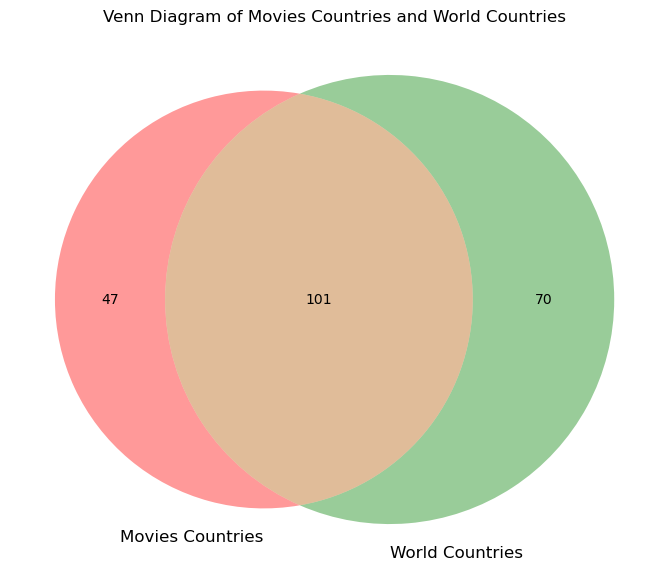

In [ ]:
#Venn diagram of countries_dict.values() (in movies_cleaned) and world['SOVEREIGNT']
#ou bien Venn diagram entre movies_cleaned['country'] et world['SOVEREIGNT']

import json
from matplotlib_venn import venn2

# Extract the sets of unique countries from df_movies and world
movies_countries = set(df_movies['countries'].explode().unique())
world_countries = set(world['SOVEREIGNT'].unique())

#--------------------------------------------MAKE A FUNCTION--------------------------------------------

# Plot the Venn diagram
plt.figure(figsize=(10, 7))
venn2([movies_countries, world_countries], ('Movies Countries', 'World Countries'))
plt.title("Venn Diagram of Movies Countries and World Countries")
plt.show()
#--------------------------------------------------------------------------------------------------------


We could expect that some countries had never published any film, but the fact that some of our films don't find any matching country on our map is going to be a problem. Thus we should explore which cases are a problem and how we could solve it.

In [ ]:
# Find the countries that are in df_movies but not in world
countries_not_in_world = movies_countries - world_countries

# Print the result
print(countries_not_in_world)


{'Malta', 'Bahamas', 'Czech Republic', 'Bahrain', 'Malayalam Language', 'Nazi Germany', 'Aruba', 'Kingdom of Great Britain', 'Republic of China', 'Republic of Macedonia', 'Puerto Rico', 'Mandatory Palestine', 'Serbia and Montenegro', 'Northern Ireland', 'Korea', 'German Democratic Republic', 'Yugoslavia', 'Palestinian territories', 'Slovak Republic', 'Ukranian SSR', 'Monaco', 'Georgian SSR', nan, 'Weimar Republic', 'Socialist Federal Republic of Yugoslavia', 'Soviet Union', 'Uzbek SSR', 'Kingdom of Italy', 'England', 'Soviet occupation zone', 'West Germany', 'Hong Kong', 'Scotland', 'Palestinian Territories', 'Crime', 'Isle of Man', 'German Language', 'Congo', 'Ukrainian SSR', 'Serbia', 'Macau', 'Burma', 'Czechoslovakia', 'Iraqi Kurdistan', 'Federal Republic of Yugoslavia', 'Singapore', 'Wales'}


We observe that three main problems appear : 
- Many film countries are named under old countries names such as 'Kingdom of Italy'
- Some countries don't exist in the geopanda map, such as Singapore
- Some countries have multiple names such as 'Czech Republic' and 'Czechia'

To solve these problems, we report some of the film countries to some existing one in the geopanda map (for example we associate every country name that refers to the same one to the geopanda name, and associate any small country to the closest bigger one).

In [ ]:
from geopanda import replace_countries

with open('data/freebaseIdDictionnaries/countries', 'r') as file:
    countries_dict = json.load(file)

geo_countries_dict = replace_countries(countries_dict)

#save the dictionary just like arnaud did

Now we have a uniform dictionnary to rely the freebase Id with its actual country, it could also be useful for some other features.

## Economics

In [ ]:
sys.path.append('src/data')

In [7]:
from importlib import reload
import additionaldataLoader
reload(additionaldataLoader)

ModuleNotFoundError: No module named 'additionaldataLoader'

In [ ]:
path = 'src/data'
sys.path.append(path)
from dataLoader import loadDataframe
from additionaldataLoader import loadAdditionalDataframe

## Culture

Genre analysis

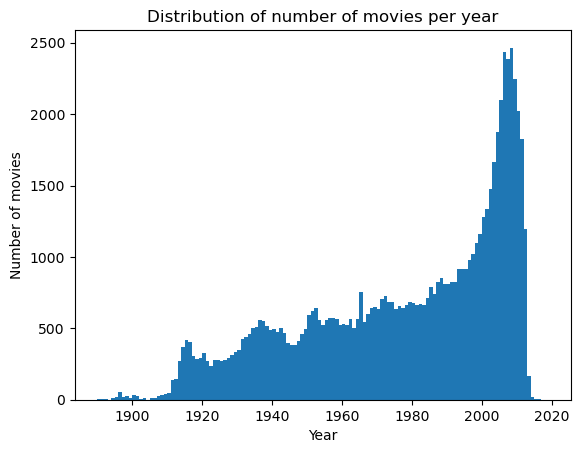

In [25]:
# Distribution of number of movies per year
plt.hist(df_movies['release_date'].dt.year, bins=range(1890, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Distribution of number of movies per year')
plt.show()

The total movies produced per year increases over time.

In [26]:
df_genres_countries_exploded = df_movies.explode('genres').explode('countries')
df_genres_countries_exploded.head(3)

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Thriller,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Science Fiction,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Horror,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."


In [27]:
print("Number of unique genres: ", df_genres_countries_exploded['genres'].nunique())

print(df_genres_countries_exploded['genres'].unique())


Number of unique genres:  363
['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' 'Animation' "Children's/Family" "Children's Fantasy"
 nan 'Future noir' 'Comedy film' 'Coming of age' 'Suspense'
 'Crime Thriller' 'Black comedy' 'Bollywood' 'Marriage Drama' 'Wuxia'
 'Martial Arts Film' 'Chinese Movies' 'Western' 'Parody' 'Mockumentary'
 'Fan film' 'Cult' 'Adventure Comedy' 'Slapstick' 'Biopic [feature]'
 'Historical Epic' 'Sports' 'Family Drama' 'Political drama'
 'Historical fiction' 'Courtroom Drama' 'Culture & Society' 'Biography'
 'Docume

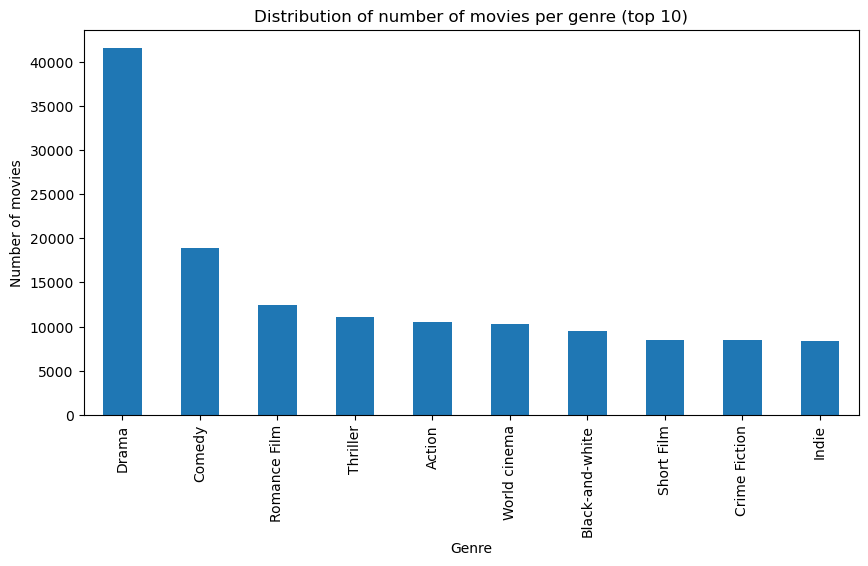

In [28]:
# Distribution of number of movies per genre (top 10)
plt.figure(figsize=(10, 5))
df_genres_countries_exploded['genres'].value_counts().head(10).plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Distribution of number of movies per genre (top 10)')
plt.show()


There are a lot of different genres in the dataset (363). The most common genres are Drama, Comedy and Romance. In the dataset, we see that some genres are quiet similar (e.g. Gay, Gay Interest, Gay Themed). In our future analysis, we could group these genres together to have a more accurate analysis.

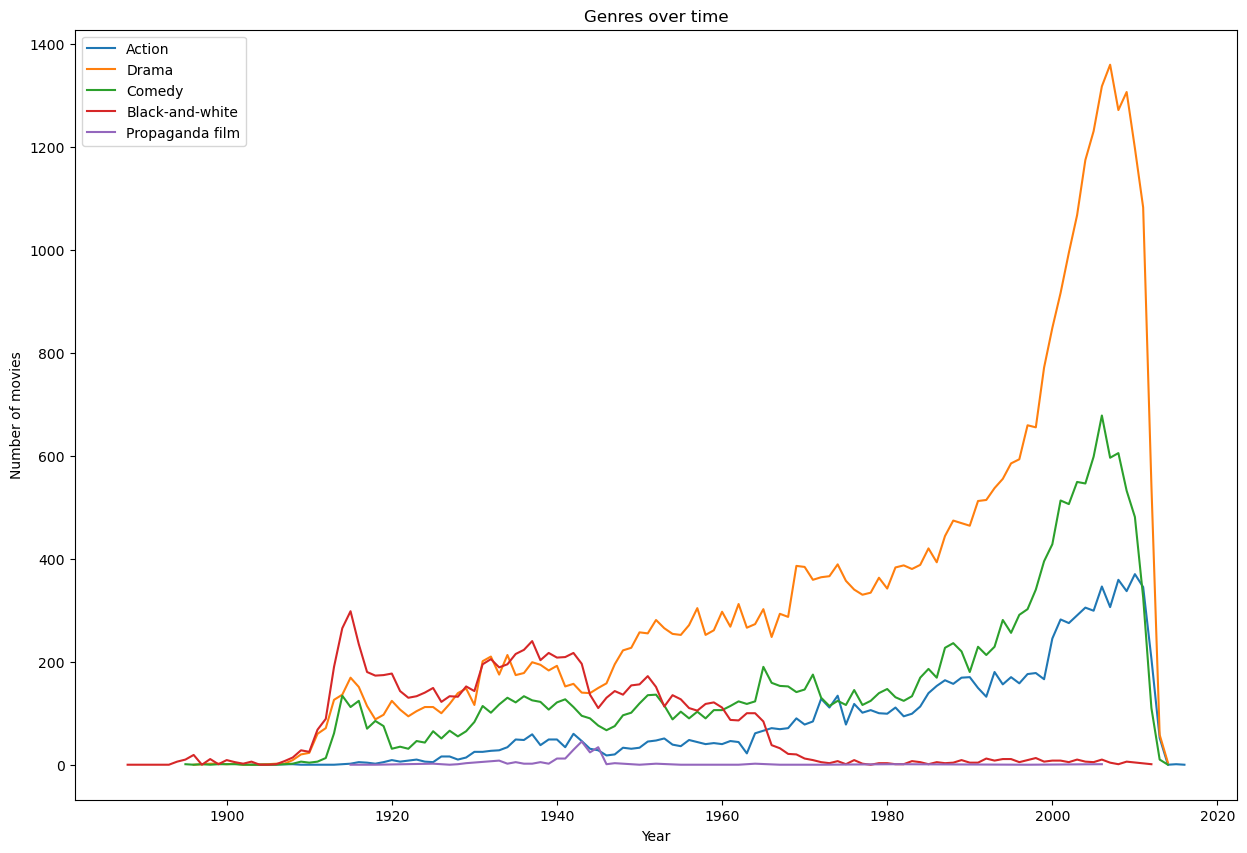

In [29]:
# Genres over time
genres = ['Action', 'Drama', 'Comedy', 'Black-and-white','Propaganda film'] 

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for genre in genres:
    df_genre = df_genres_countries_exploded[df_genres_countries_exploded['genres'] == genre]
    df_genre = df_genre.groupby(df_genre['release_date'].dt.year).size()
    df_genre.plot(ax=ax, label=genre)
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Genres over time')
plt.legend()
plt.show()

On the previous graph, we can see the evolution for the whole world of the number of movies per genres produced over time. Some genres are decreasing over time (e.g. Black and White), some genres appear temporarly (e.g. Propaganda film) and some genres are increasing over time (e.g. Action, Drama).

In [30]:
df_genres_countries_exploded.head()

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Thriller,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Science Fiction,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Horror,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Adventure,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Supernatural,['/m/09c7w0'],['/m/02h40lc'],"['/m/01jfsb', '/m/06n90', '/m/03npn', '/m/03k9..."


C:\Users\arnau\AppData\Local\Temp\ipykernel_27328\675473540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['release_date'] = pd.to_datetime(df_filtered['release_date'], errors='coerce')
C:\Users\arnau\AppData\Local\Temp\ipykernel_27328\675473540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['release_date'], inplace=True)
C:\Users\arnau\AppData\Local\Temp\ipykernel_27328\675473540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

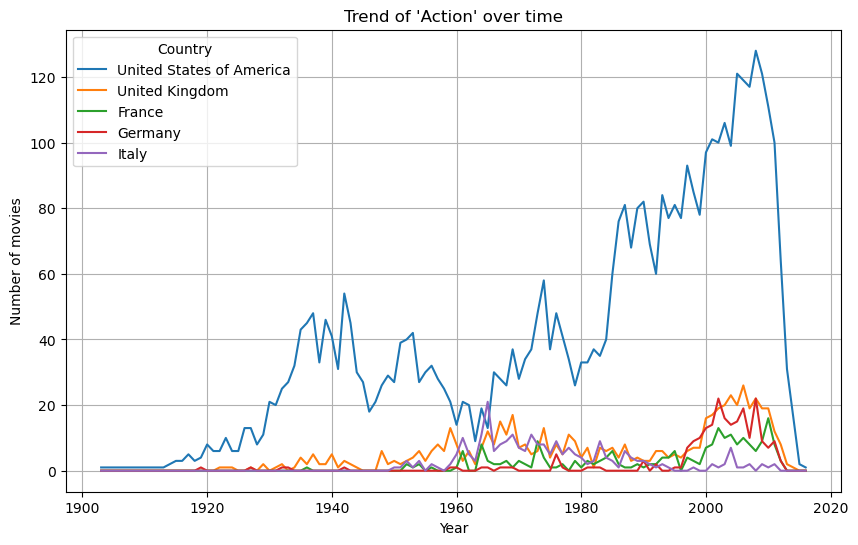

In [31]:
# Genre evolution per country
def plotGenreTrend(df, countries, genre):
    df_filtered = df[(df['genres'] == genre) & (df['countries'].isin(countries))]
    df_filtered['release_date'] = pd.to_datetime(df_filtered['release_date'], errors='coerce')
    df_filtered.dropna(subset=['release_date'], inplace=True)
    df_filtered['year'] = df_filtered['release_date'].dt.year
    trend_data = df_filtered.groupby(['countries', 'year']).size().unstack(fill_value=0)
    
    plt.figure(figsize=(10, 6))
    for country in countries:
        if country in trend_data.index:
            plt.plot(trend_data.columns, trend_data.loc[country], label=country)
    
    plt.title(f"Trend of '{genre}' over time")
    plt.xlabel("Year")
    plt.ylabel("Number of movies")
    plt.legend(title="Country")
    plt.grid(True)
    plt.show()
    
countries = ['United States of America', 'United Kingdom', 'France', 'Germany', 'Italy']
genre = 'Action'
plotGenreTrend(df_genres_countries_exploded, countries, genre)

In the previous graph, we can see an example of the evolution of the number of movies produced for genre 'Action' over time for different countries. It is noted that the United States is a pioneer in the production of action films and that after the explosion of action films in the United States, other countries followed the trend, which may indicate an influence of the United States on other countries and be linked to globalization.

Topic modelling

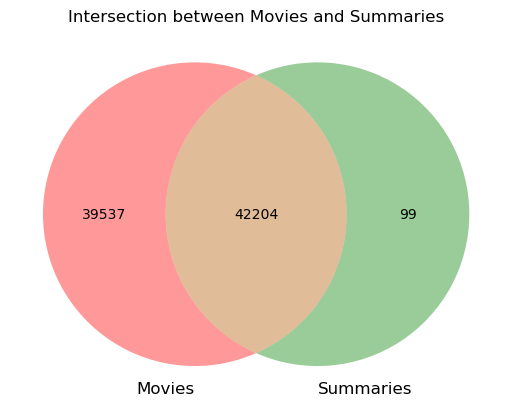

In [32]:
intersectionWikiId(df_movies, df_summaries, 'Movies', 'Summaries', id_column='wiki_id')

More than 50% of the movies have a summary, which is enough to make a topic modelling analysis.

In [33]:
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from tqdm import tqdm

# Load the spaCy model for English language
nlp = spacy.load("en_core_web_sm")

# Download stopwords and punkt tokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load the English stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Tokenisation
    doc = nlp(text.lower())  # Convert to lowercase
    
    # Lemmatisation and remove stopwords and punctuation
    processed_tokens = [
        token.lemma_ for token in doc if token.text not in stop_words and token.text not in string.punctuation
    ]
    
    return " ".join(processed_tokens)

ModuleNotFoundError: No module named 'srsly.ujson.ujson'

In [ ]:
# Apply the preprocessing to the summaries
df_summaries_small = df_summaries.sample(1000)

tqdm.pandas()
df_summaries_small['cleaned_summary'] = df_summaries_small['summary'].progress_apply(preprocess_text)

100%|██████████| 42303/42303 [40:59<00:00, 17.20it/s]  


In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [ ]:
# Create the SentenceTransformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the summaries
embeddings = embedding_model.encode(df_summaries_small['cleaned_summary'].tolist(), show_progress_bar=True)

# Create the BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)

# Fit the BERTopic model
topics, probabilities = topic_model.fit_transform(df_summaries_small['cleaned_summary'].tolist())

# Assign the topics to the summaries
df_summaries_small['topic'] = topics

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-11-13 21:13:12,799 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-11-13 21:14:01,989 - BERTopic - Embedding - Completed ✓
2024-11-13 21:14:01,995 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-13 21:14:05,554 - BERTopic - Dimensionality - Completed ✓
2024-11-13 21:14:05,554 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-13 21:14:05,600 - BERTopic - Cluster - Completed ✓
2024-11-13 21:14:05,603 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-13 21:14:05,836 - BERTopic - Representation - Completed ✓


In [ ]:
# Display the topics
topic_info = topic_model.get_topic_info()
print(topic_info)

# Visualize the topics
topic_model.visualize_topics()

    Topic  Count                             Name  \
0      -1    466              -1_go_take_find_one   
1       0    202              0_find_tell_go_take   
2       1    101        1_love_father_get_village   
3       2     60           2_film_war_soldier_man   
4       3     53  3_father_wife_love_relationship   
5       4     30            4_bug_tom_jerry_elmer   
6       5     23   5_murder_evans_christie_police   
7       6     23   6_dastan_tamina_michiru_dagger   
8       7     19       7_story_woman_chopin_mayil   
9       8     13     8_ship_boat_captain_finnegan   
10      9     10     9_stooge_droopy_curly_elaine   

                                       Representation  \
0   [go, take, find, one, get, leave, film, man, f...   
1   [find, tell, go, take, leave, get, see, one, k...   
2   [love, father, get, village, marry, family, ta...   
3   [film, war, soldier, man, german, d8, british,...   
4   [father, wife, love, relationship, max, life, ...   
5   [bug, tom, jerry,

We implement a test to try the topic modelling of Bertopic, but it has to be improved.

### Theme Study for Cultural Influence Analysis

In [7]:
import sys
sys.path.append('src/scripts')

from scriptCulture import process_data_us_influence          # Import the function that processes the data for this study

df_us_influence = process_data_us_influence()
df_us_influence.head()

,Country,US_Term_Count,Number of movies,Influence_score,log_number_of_movies,World_region
0,France,531,2297,0.231171,7.739359,Europe
1,Soviet Union,30,255,0.117647,5.541264,Eastern Europe and Central Asia
2,Russia,18,217,0.082949,5.379897,Eastern Europe and Central Asia
3,United States of America,7657,20789,0.368320,9.942179,North America
4,India,262,4752,0.055135,8.466321,South Asia


For this analysis, we identified a list of typically american words. We then search for this words occurences in the different summaries. We then grouped the results by countries.

The processed dataset that we'll use for this analyse is completed with the features :
 - US_Term_Count : Number of us terms found in the movies from each country
 - Number of movies : number of movies in each country
 - Influence score : ratio of US_Term_Count/Number of movies
 - World_region : Geographical cluster that we identified 


In [6]:
from importlib import reload
import scriptCulture
reload(scriptCulture)

<module 'scriptCulture' from 'c:\\Users\\Oscar\\Project ADA\\ada-2024-project-teamcsx24\\src/scripts\\scriptCulture.py'>

In [8]:
df_us_influence.describe()

,US_Term_Count,Number of movies,Influence_score,log_number_of_movies
count,147.000000,147.000000,147.000000,147.000000
mean,85.088435,321.510204,0.147156,3.290563
std,639.985937,1797.950894,0.230474,1.925694
min,0.000000,2.000000,0.000000,0.693147
25%,0.000000,6.000000,0.000000,1.791759
50%,2.000000,17.000000,0.090909,2.833213
75%,14.000000,101.000000,0.202210,4.615121
max,7657.000000,20789.000000,2.000000,9.942179


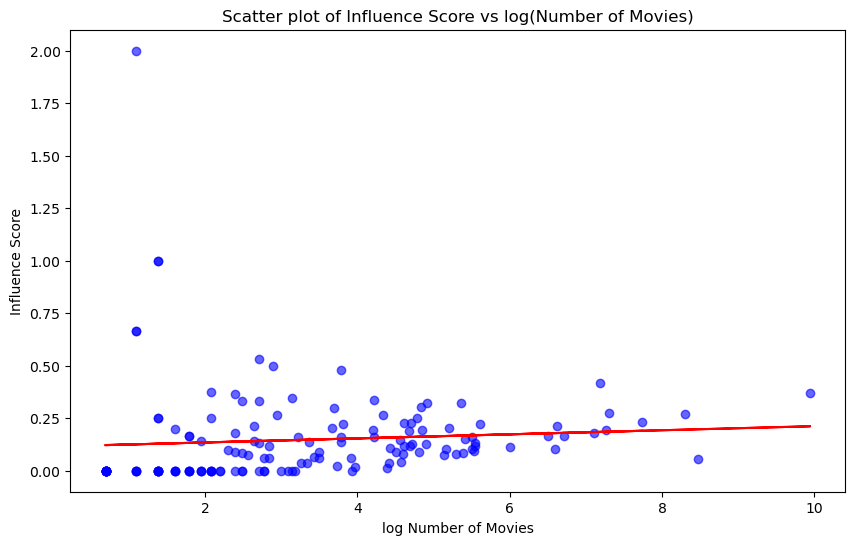

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(
    df_us_influence['log_number_of_movies'], 
    df_us_influence['Influence_score'], 
    color='blue', 
    alpha=0.6
)
#add the linear regression line
z = np.polyfit(df_us_influence['log_number_of_movies'], df_us_influence['Influence_score'], 1)
p = np.poly1d(z)
plt.plot(df_us_influence['log_number_of_movies'],p(df_us_influence['log_number_of_movies']),"r-")
plt.title('Scatter plot of Influence Score vs log(Number of Movies)')
plt.xlabel('log Number of Movies')
plt.ylabel('Influence Score')

plt.show()

Too Many small countries with few films, resulting in a high standard deviation (more than 6 times the average term count) and not relevant linear regression, clustering was necessary. The first clustering that seemed the most logical to us was geographical clustering.


C:\Users\Oscar\AppData\Local\Temp\ipykernel_32776\3488935404.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
C:\Users\Oscar\AppData\Local\Temp\ipykernel_32776\3488935404.py:8: UserWarning: 
The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))


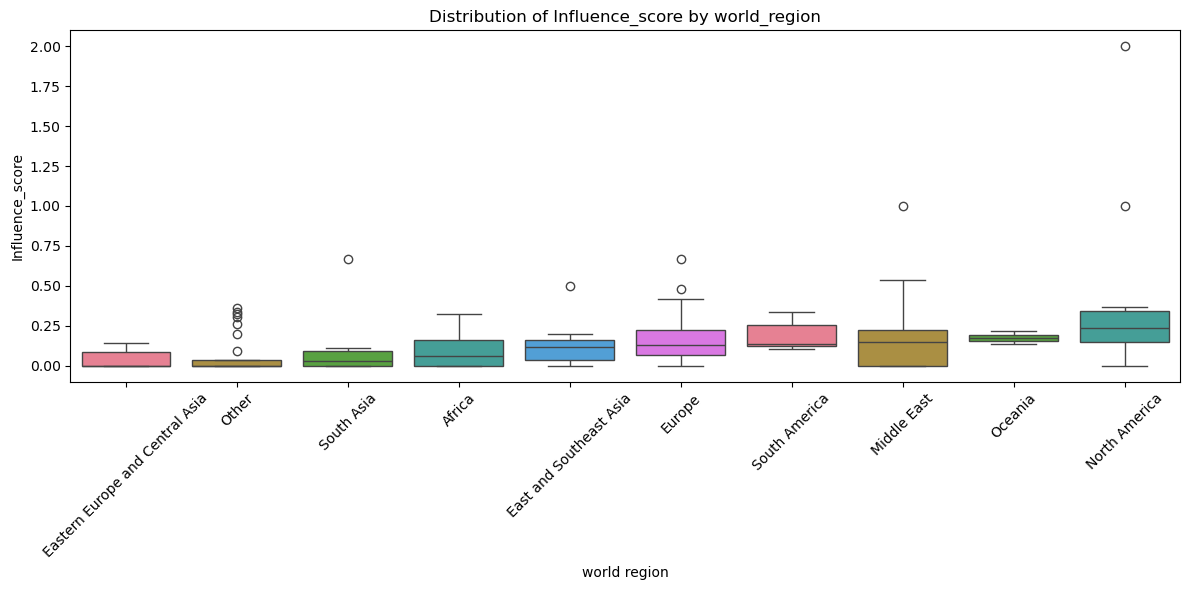

In [10]:
import seaborn as sns

plt.figure(figsize=(12, 6))
# Sort by median ratio
median_order = df_us_influence.groupby('World_region')['Influence_score'].median().sort_values().index

# Create the boxplot with the sorted order
sns.boxplot(x='World_region', y='Influence_score', data=df_us_influence, order=median_order, palette=sns.color_palette("husl"))
plt.title('Distribution of Influence_score by world_region')
plt.xlabel('world region')
plt.ylabel('Influence_score')


plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [11]:
df_us_influence.groupby('World_region')['Influence_score'].describe() #Checking the uniformity of the clusters regarding our feature

,count,mean,std,min,25%,50%,75%,max
World_region,,,,,,,,
Africa,17.0,0.087246,0.094800,0.000000,0.000000,0.060606,0.159091,0.323529
East and Southeast Asia,13.0,0.128948,0.128923,0.000000,0.036145,0.113580,0.162602,0.500000
Eastern Europe and Central Asia,9.0,0.038162,0.059185,0.000000,0.000000,0.000000,0.082949,0.142857
Europe,42.0,0.161546,0.148088,0.000000,0.065202,0.127815,0.224474,0.666667
Middle East,11.0,0.209803,0.309140,0.000000,0.000000,0.147368,0.222656,1.000000
North America,10.0,0.448792,0.611118,0.000000,0.148810,0.236722,0.344772,2.000000
Oceania,2.0,0.173358,0.057340,0.132812,0.153085,0.173358,0.193631,0.213904
Other,29.0,0.065831,0.123967,0.000000,0.000000,0.000000,0.035714,0.363636
South America,8.0,0.182935,0.086291,0.101215,0.124561,0.135632,0.253289,0.333333


The geographical clusters are not very uniform (2 countries for Oceania vs 42 for Europe), and not homogeneous regarding the ratio feature. Indeed, we observe a high standard deviation in each country. This cluster is very interesting in term of interpretability but we should consider another clustering method to solve these issues.

Areas for improvement for this study:

 - The identification of US-related terms could be enhanced, either manually or through more advanced techniques. We have begun exploring Natural Language Processing (NLP) methods that could assist with this task and even enable us to assess the influence of each country on others based on the themes present in the film summaries. We started to look at Transformer from HuggingFace and Spacy that could be used for this task

 - The current geographical clustering may not be optimal due to its lack of uniformity and the high variance in the ratios. To address this, we plan to experiment with clustering algorithms like KNN or centroids (as we can define an euclidian distance with the ratio) to achieve more homogeneous,uniform and interpretable clusters.




### NLP methods utilization

In [12]:
import spacy

nlp = spacy.load("en_core_web_sm")

#Summary example
resume = "The character travels through the streets of Paris, facing challenges that test his courage. He then fly straight to Spain"

# We apply the NLP model to the summary
doc = nlp(resume)

# Extract the geographical entities from the summary
pays_detectes = [ent.text for ent in doc.ents if ent.label_ == "GPE"]  # GPE = Geopolitical Entity

print(pays_detectes)

['Paris', 'Spain']


We will expand our analysis by exploring the influence of specific cities or countries on movie themes. One approach would be to create an additional influence feature based on the frequency of mentions of cities or countries in the movie summaries. This would allow us to quantify the impact of these locations on the themes, potentially revealing patterns of cultural influence or regional trends within the film industry.

In [ ]:
from transformers import pipeline

# Here we use the zero-shot-classification pipeline
nlp = pipeline("zero-shot-classification")

# movie summary example
resume = "Five men attend the same gym in Berlin. None of them seem to have anything in common, but all five have not enough confidence to meet or develop relationships with the opposite sex, and what it really means to be a man or what women expect of them. Günther Stobanski, portrayed by Christian Ulmen, fails with Internet dating, music producer Jerome Ades, portrayed by Til Schweiger, passes from a sentimental break-up story to another. Roland Feldberg, a train driver portrayed by Wotan Wilke Möhring, snubs his wife Susanne Feldberg portrayed by Nadja Uhl. The girlfriend of Philip Henrion, portrayed by Maxim Mehmet, becomes pregnant at a young age. Niklas Michalke, a solicitor portrayed by Florian David Fitz, is terrified by his impending marriage, while Bruce Berger, a singer portrayed by Justus von Dohnányi, tries to pursue his singing career."

# Here we define the label (countries in our case)
labels = ["United States", "France", "India", "Germany"]

result = nlp(resume, candidate_labels=labels)

# The result is a dataframe with the labels and their respective scores
df_result = pd.DataFrame(list(zip(result['labels'], result['scores'])), columns=['Label', 'Score'])

df_result.head()

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


,Label,Score
0,Germany,0.887495
1,India,0.043266
2,France,0.041677
3,United States,0.027562


The function classifies the movie summary by calculating the likelihood that represent the probability that the events in the movie take place in a specific country, using a pre-trained zero-shot model. This means the model doesn't need to be retrained on the specific countries, as it has already learned general language patterns and can apply them to this kinf of task.

This second approach can be very useful for enriching our analysis about cultural influence, especially by applying a threshold to filter the results, which adds depth to the explanations. We will also evaluate the model's performance by testing precision, recall, and accuracy across several labeled summaries. Additionally, experimenting with different thresholds when displaying the results could provide further insights. The F-score could also be a valuable metric to assess the balance between precision and recall.

### Character Study for Cultural Influence Analysis

In [15]:
import sys
sys.path.append('src/scripts')

from scriptCulture import process_data_character          # Import the function that processes the data for this study

df_character_influence = process_data_character()
df_character_influence.head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
0,'Baby' Louise,/m/0c0lv89,Diane Pace,Gypsy,1962-01-01,[United States of America],[United States of America],1
1,ACP Jai Dixit,/m/0220_c2,Abhishek Bachchan,Dhoom,2004-08-27,[India],[India],1
2,Abigail Chase,/m/0k14v6,Diane Kruger,National Treasure,2004-11-08,[United States of America],[United States of America],1
3,Abraham Lincoln,/m/0k89pf,Henry Fonda,Young Mr. Lincoln,1939-01-01,[United States of America],[United States of America],1
4,Abraham Van Helsing,/m/0jxjsg,Edward Van Sloan,Dracula,1931-02-12,[United States of America],"[France, Spain, United Kingdom, United States ...",4


For this analysis, we grouped the characters that appeared in different countries (from the character_cluster database). 

The processed dataset that we'll use for this analyse is completed with the features :
 - first_movie_name : The first movie in which the character appeared
 - first_apperance_date : The date of release of the first movie 
 - origin_country : The country of the first movie
 - all_countries : the countries of origin of all the movies in which the character has appeared 
 - number_countries : count of all_countries


In [16]:
df_character_influence.describe()

,number_countries
count,970.000000
mean,1.797938
std,1.161116
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,8.000000


970 characters appear in multiple films; on average, they appear in 1.8 different countries. They feature in up to 8 different films. Let's look at the distribution of the number of countries

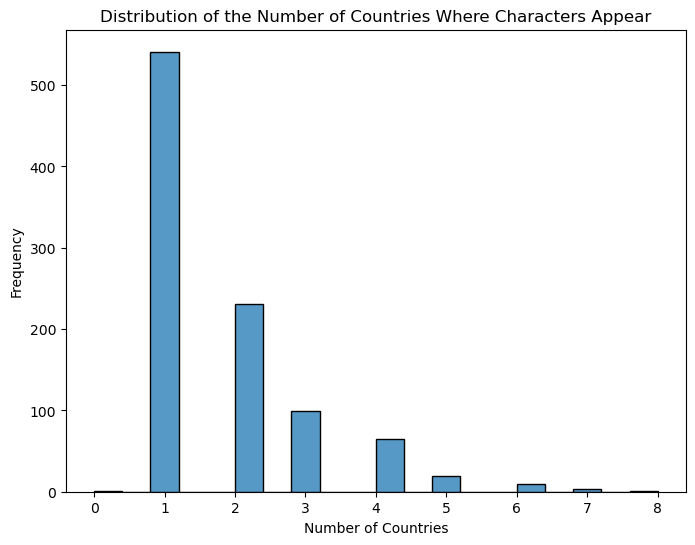

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(df_character_influence['number_countries'], kde=False, bins=20)

plt.title('Distribution of the Number of Countries Where Characters Appear')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

plt.show()

In [ ]:
print(df_character_influence[df_character_influence['number_countries'] > 1].count()) #Number of characters that appear in more than one country
print("number of influence point to be given :",df_character_influence['number_countries'].sum()-970) #Number of influence point to be given

Character                      428
character_actor_freebase_id    428
actor_name                     428
first_movie_name               428
first_apperance_date           428
origin_country                 428
all_countries                  428
number_countries               428
dtype: int64
number of influence point to be given : 774


Of the 970 characters, 428 appear in movies produced across different countries, which is not a large sample. We will keep this in mind as we test the significance of our study.

For each character appearing in a movie produced by a different country, we will assign 1 influence point to the character's origin country. This results in a total of 774 points being assigned.

A major concern that remains is whether the method of taking the first movie appearance as the origin country of a character is reliable.

Let's test this with the character that appears in movies produced in the most countries.

In [ ]:
#find the character that appear in 8 countries and show all the origin countries one by one

df_character_influence[df_character_influence['number_countries'] == 8].head()

,Character,character_actor_freebase_id,actor_name,first_movie_name,first_apperance_date,origin_country,all_countries,number_countries
120,Cardinal Richelieu,/m/02vbtwv,Charlton Heston,The Three Musketeers,1973-01-01,"[United States of America, Spain, United Kingdom]","[Australia, Spain, Austria, Panama, United Sta...",8


The character appearing in productions from the most different countries is Cardinal Richelieu (French origin). However, with our initial method, the influence points would not have been distributed to France but to UK, US and Spain.

This analysis drives us to explore other methods for identifying character origins. One possibility is to leverage Natural Language Processing (NLP) models, such as spaCy to analyze movie summaries geographical terms and better determine the character's origin. 

Additionally, using embedding models like Hugging Face transformers could help identify implicit relationships within the movie summaries and find where the history of the movie take place and deduct the characters origin from this.

## Population

### I. Studying the international careers of actors

The goal of this part is to see whether actors tend to have more international careers. The final goal of this part is to plot a map of the world in which two countries are linked by an edge if an actor has played in those two countries. The size of the edges will depend on the number of actors.

This plot will allow us to see how the number of connections evolved and to look for the eventual emergence of clusters.

### 1. Analysis of the data on actors who have an international career

For this first analysis, we started by looking only at the single productions and excluding co-productions. 

It seems that co-productions are the initiatives of the productors and not of the actors. Therefore, they do not really reflect the movements of population associated with globalization. Indeed, if an american actor played in an americano-indian movie, it cannot really be considered as an international career. Moreover, one single co-production involves a lot of actors which might completely drawn the data from single productions.

In this process, we might loose informations about actors who participated in co-production that did not include their country of origin and otherwise never performed abroad. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

In [ ]:
# Creating a dataframe that contains only lines associated with single production movies

import sys
sys.path.append('../scripts')

from importlib import reload
import populationScripts as ps      # Import the function that processes the data for this study
reload(populationScripts)

df_single_prod = ps.createSingleProdDf()
df_single_prod.head()

c:\Users\richa\OneDrive\Documents\EPFL\MA1\ada\ada-2024-project-teamcsx24\src\analysisResearch\../scripts\populationScripts.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,wiki_id,freebase_id,release_date,character,birth_date,gender,height,ethnicity_freebase_id,name,age,character_actor_freebase_id,character_freebase_id,actor_freebase_id,countries_freebase_id,number_production_countries
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,['/m/09c7w0'],1
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,['/m/09c7w0'],1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,['/m/09c7w0'],1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,['/m/09c7w0'],1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,['/m/09c7w0'],1


In [ ]:
#comparison between the total number of movies and the number of co-productions
print(ps.comparisonSingleCoProd())
print(ps.comparisonActors())

('Number of single production : 112', 'Total number of movies production : 1867')
('Number of single production : 114291', 'Total number of movies production : 134384')


The number of movies resulting from single-production is quite small. However, it seems that our study still include the majority of the actors. 

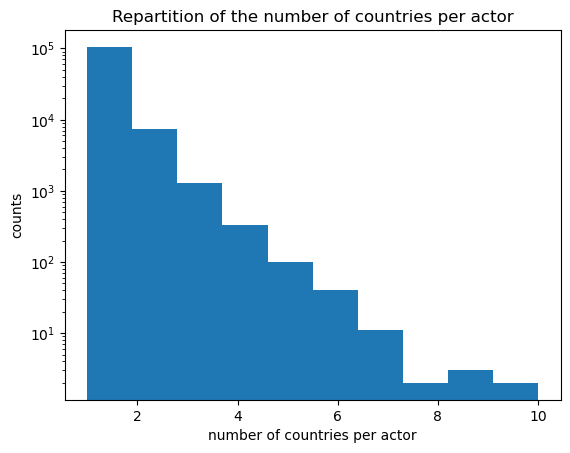

In [ ]:
# Plot showing the number of countries in which actors have played

number_countries_per_actor = ps.numberCountriesPerActor()

#let's plot the result
plt.hist(number_countries_per_actor, log=True)
plt.xlabel('number of countries per actor')
plt.ylabel('counts')
plt.title('Repartition of the number of countries per actor')
plt.show()

In [ ]:
# dataframe containing only the international actors
# statistics on the number of actors and the number of countries that will be involved in our final graph
df_international_actors = ps.createInternationalActorDf()
df_international_actors.head()

,wiki_id,freebase_id,release_date,character,birth_date,gender,height,ethnicity_freebase_id,name,age,character_actor_freebase_id,character_freebase_id,actor_freebase_id,countries_freebase_id_x,number_production_countries,countries_freebase_id_y
0,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,['/m/09c7w0'],1,2
1,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,['/m/09c7w0'],1,2
2,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02 00:00:00,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,['/m/09c7w0'],1,2
3,975900,/m/03vyhn,2001-08-24,McSimms,1944-07-22 00:00:00,M,1.800,NaN,Peter Jason,57.0,/m/0bgchxd,/m/0bgchxh,/m/03d663h,['/m/09c7w0'],1,2
4,975900,/m/03vyhn,2001-08-24,Benchley,1935-08-13 00:00:00,M,NaN,NaN,Doug McGrath,66.0,/m/0bgcj4p,/m/0bgcj4s,/m/02r5d3j,['/m/09c7w0'],1,2


In [ ]:
# Computing the number of countries 
print(ps.numberCountries())

102 countries will be represented in our graph, 1867 were initially present in the data


Overall, the choice to focus on single-productions make us study a small part of the data. It would be interesting to compare those results with a similar study involving the co-productions to see if the small number if countries comes from the fact that most data was lost, or if it is just because a lot of countries do not have an international movie industry.

However, the data on single-productions is a good sample to test the faisibility of the graph.

### 2. Feasibility of the graph

The final goal of this part is to plot a map of the world in which two countries are linked by an edge if an actor has played in those two countries.

To study the feasibility of this goal, we used networkx to see if the realization of a graph with our data was feasible and relevant.

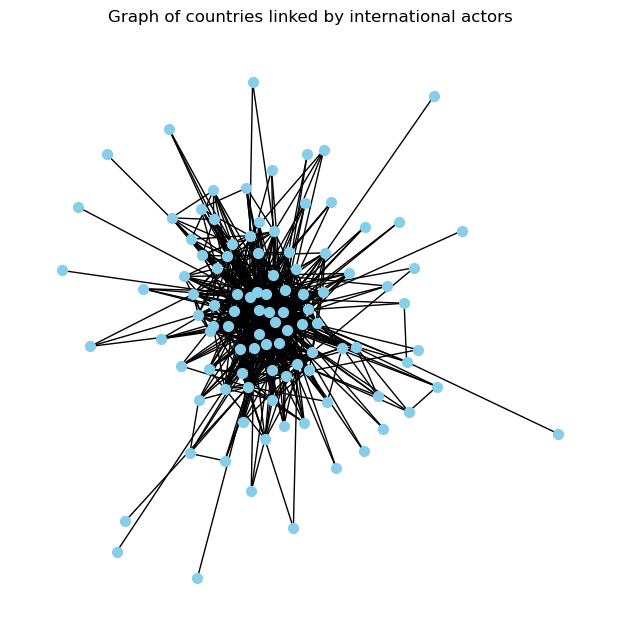

In [ ]:
# first visualization as a graph
G = ps.getGraph()

plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=False, node_color='skyblue', node_size=50, font_size=6, width = 1)
plt.title("Graph of countries linked by international actors")
plt.show()

Plotting a graph seems feasible. However several steps remain before obtaining the final version :

- Our first graph includes all the years. We should separate the data per year
- Making the plot interactive by allowing the user to change the date
- Adding the co-productions and comparing the results
- Using a dictionary to add the names of the countries
- Linking the countries with the ones from the geopanda library to plot the graph as a map

### II. Ethnicities analysis

### 1. Evolution of diversity

In this part we will check if the number of ethnicities in movies has indeed evolved.

In [ ]:
# Creating a dataset for the study
df_ethnicities = ps.createEthicitiesDf()
df_ethnicities.head()

,wiki_id,freebase_id,release_date,character,birth_date,gender,height,ethnicity_freebase_id,name,age,character_actor_freebase_id,character_freebase_id,actor_freebase_id,release_year
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26 00:00:00,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,2001
11,975900,/m/03vyhn,2001-08-24,Tres,1959-03-09 00:00:00,M,NaN,/m/064b9n,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb,2001
27,3196793,/m/08yl5d,2000-02-16,NaN,1937-11-10 00:00:00,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp,2000


In [ ]:
number_ethnicities = df_ethnicities['ethnicity_freebase_id'].nunique()
print(number_ethnicities)

477


Text(0.5, 1.0, 'Evolution of the number of ethnies per movie')

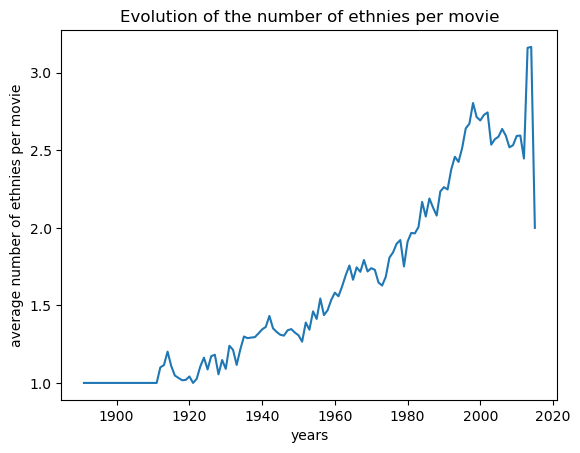

In [ ]:
# plot of the evolution of diversity in movies
average_ethnicity_per_year = ps.averageEthnicityPerYear() #the average is computed by grouping the ethnicity dataframe by year and by ethnicity

plt.plot(average_ethnicity_per_year.index, average_ethnicity_per_year.values)
plt.xlabel('years')
plt.ylabel('average number of ethnies per movie')
plt.title('Evolution of the number of ethnies per movie')

The number of ethnicities per movie is increasing. It is therefore relevant to study it.

### 2. Looking at the ethnicities in details

Our initial idea was to plot a stacked barchart to see the evolution of each category of ethnicies independently.
Since there are too many ethnicities for the plot to be understandable, we wanted to group the ethnicities by continent or region of origin in order to compare how different regions of the world are involved in the globalization of the movie industry.

However, linking each ethnicity with a continent, a region or even a country was not possible. Too much data was missing from the Freebase.

We tried to see if focusing only on the most represented ethnicities was relevant.

Text(0.5, 1.0, 'Representation of each ethnicity in the dataframe')

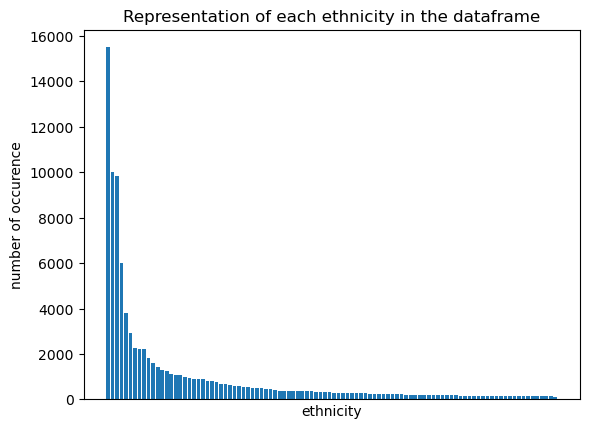

In [ ]:
# plotting the repartition of each ethnicity in the dataframe
ethnicity_representation = df_ethnicities['ethnicity_freebase_id'].value_counts()[:100]
plt.bar(ethnicity_representation.index, ethnicity_representation.values)
plt.ylabel('number of occurence')
plt.xlabel('ethnicity')
plt.xticks([])
plt.xticks(rotation = 'vertical', fontsize = 5)
plt.title('Representation of each ethnicity in the dataframe')

As we can see on the previous plot, all ethnicities are not equally represented in the dataframe. Since we will be looking at proportions of each ethnicity in movies overtime, the less represented ethnicities will have a negligeable proportion. Therefore, it seems relevant to focus on the 15 most represented ethnicities.

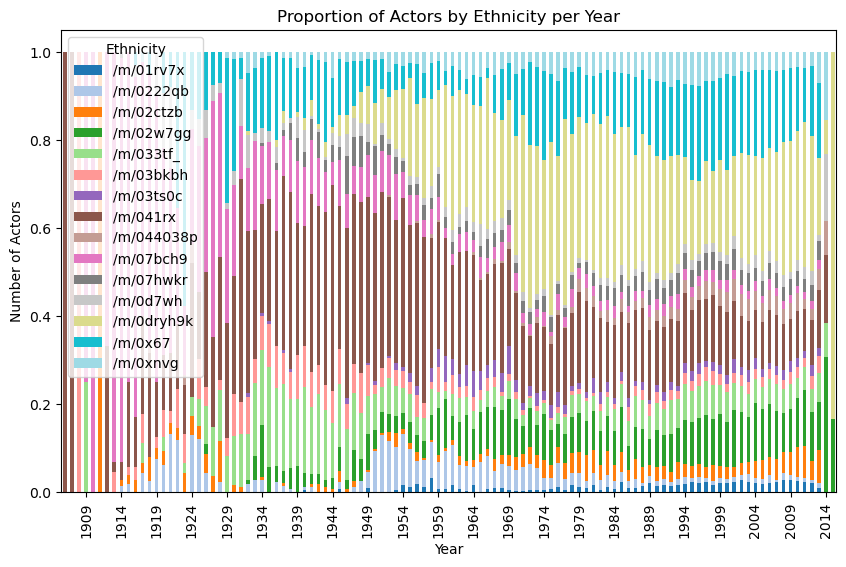

In [ ]:
# plotting the evolution of the proportion of each ethnicity in movies overtime, for the 15 most representeed ethnicities
# list of the 10 most represented ethnicities
ten_main_ethnicities = df_ethnicities['ethnicity_freebase_id'].value_counts()[:15].index

# selecting the most represented ethnicities
main_ethnicities = df_ethnicities[df_ethnicities['ethnicity_freebase_id'].isin(ten_main_ethnicities)]
main_ethnicities_grouped = main_ethnicities.groupby(['release_year', 'ethnicity_freebase_id']).size().unstack(fill_value=0)

# Normalizing the data
main_ethnicities_normalized = main_ethnicities_grouped.div(main_ethnicities_grouped.sum(axis=1), axis=0)

main_ethnicities_normalized.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 6))

plt.xlabel('Year')
plt.xticks(np.arange(3,110,step = 5))
plt.ylabel('Number of Actors')
plt.title('Proportion of Actors by Ethnicity per Year')
plt.legend(title='Ethnicity')
plt.show()

As we can see on the previous plot, even with 15 ethnicities some ethnicities have very small areas on the stacked barchart. It seems relevant to focus only on those countries, since the other will barely be visible on the plots.

### Languages study by country

In [ ]:
with open('data/freebaseIdDictionnaries/languages', 'r') as file:
    languages_dict = json.load(file)

#
#df_movies['countries_freebase_id'] = df_movies['countries_freebase_id'].apply(eval)

# Explode the lists in 'countries_freebase_id' and 'languages_freebase_id' columns
movies_df_exploded = df_movies.explode('countries_freebase_id').explode('languages_freebase_id')

# Group by 'countries_freebase_id' and count unique 'languages_freebase_id'
max_languages_per_country = movies_df_exploded.groupby('countries_freebase_id')['languages_freebase_id'].nunique()

# Order the result from biggest to smallest
max_languages_per_country_sorted = max_languages_per_country.sort_values(ascending=False)

# Map the index to country names using countries_dict
max_languages_per_country_sorted.index = max_languages_per_country_sorted.index.map(countries_dict.get)

#print the index of max_languages_per_country_sorted
print(max_languages_per_country_sorted)

countries_freebase_id
United States of America    622
France                      428
Germany                     369
United Kingdom              334
Italy                       176
                           ... 
Germany                       1
Iraq                          1
Israel                        1
Russia                        1
Guinea-Bissau                 1
Name: languages_freebase_id, Length: 147, dtype: int64
